### Loading Python libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Loading the data

In [ ]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
df_full = pdr.get_data_yahoo("LT.NS", start="2022-01-03",end="2024-02-25").reset_index()
df_full.to_csv('LT.csv',index=False)
df_full.head()


[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,1895.000000,1937.449951,1893.650024,1922.849976,1894.265625,1906676
1,2022-01-04,1922.849976,1943.000000,1914.550049,1937.550049,1908.747192,1643920
2,2022-01-05,1940.699951,1951.000000,1927.650024,1948.599976,1919.632812,1711667
3,2022-01-06,1944.500000,1953.000000,1919.599976,1924.500000,1895.891113,1372015
4,2022-01-07,1929.050049,1934.949951,1897.150024,1904.900024,1876.582520,1447123


Text(0.5, 1.0, 'Closing Price')

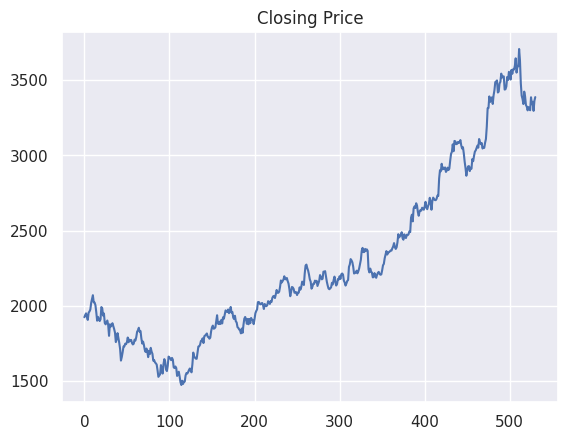

In [ ]:
df_full['Close'].plot()
plt.title('Closing Price')

In [ ]:
df_full = pd.read_csv('LT.csv')

## Actor-critic agent






In [ ]:
from collections import deque
import random
import tensorflow as tf

df= df_full.copy()
name = 'Actor-critic agent'

class Actor:
    def __init__(self, name, input_size, output_size, size_layer):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, (None, input_size))
            feed_actor = tf.layers.dense(self.X, size_layer, activation = tf.nn.relu)
            self.logits = tf.layers.dense(feed_actor, output_size)

class Critic:
    def __init__(self, name, input_size, output_size, size_layer, learning_rate):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, (None, input_size))
            self.Y = tf.placeholder(tf.float32, (None, output_size))
            self.REWARD = tf.placeholder(tf.float32, (None, 1))
            feed_critic = tf.layers.dense(self.X, size_layer, activation = tf.nn.relu)
            feed_critic = tf.layers.dense(feed_critic, output_size, activation = tf.nn.relu) + self.Y
            feed_critic = tf.layers.dense(feed_critic, size_layer//2, activation = tf.nn.relu)
            self.logits = tf.layers.dense(feed_critic, 1)
            self.cost = tf.reduce_mean(tf.square(self.REWARD - self.logits))
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)

class Agent:

    LEARNING_RATE = 0.01
    BATCH_SIZE = 32
    LAYER_SIZE = 256
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    MEMORY_SIZE = 300
    COPY = 1000
    T_COPY = 0

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.actor = Actor('actor-original', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE)
        self.actor_target = Actor('actor-target', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE)
        self.critic = Critic('critic-original', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.critic_target = Critic('critic-target', self.state_size, self.OUTPUT_SIZE,
                                    self.LAYER_SIZE, self.LEARNING_RATE)
        self.grad_critic = tf.gradients(self.critic.logits, self.critic.Y)
        self.actor_critic_grad = tf.placeholder(tf.float32, [None, self.OUTPUT_SIZE])
        weights_actor = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='actor')
        self.grad_actor = tf.gradients(self.actor.logits, weights_actor, -self.actor_critic_grad)
        grads = zip(self.grad_actor, weights_actor)
        self.optimizer = tf.train.AdamOptimizer(self.LEARNING_RATE).apply_gradients(grads)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    def _assign(self, from_name, to_name):
        from_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=from_name)
        to_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=to_name)
        for i in range(len(from_w)):
            assign_op = to_w[i].assign(from_w[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, dead):
        self.MEMORIES.append((state, action, reward, new_state, dead))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            prediction = self.sess.run(self.actor.logits, feed_dict={self.actor.X:[state]})[0]
            action = np.argmax(prediction)
        return action

    def _construct_memories_and_train(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.sess.run(self.actor.logits, feed_dict={self.actor.X: states})
        Q_target = self.sess.run(self.actor_target.logits, feed_dict={self.actor_target.X: states})
        grads = self.sess.run(self.grad_critic, feed_dict={self.critic.X:states, self.critic.Y:Q})[0]
        self.sess.run(self.optimizer, feed_dict={self.actor.X:states, self.actor_critic_grad:grads})

        rewards = np.array([a[2] for a in replay]).reshape((-1, 1))
        rewards_target = self.sess.run(self.critic_target.logits,
                                       feed_dict={self.critic_target.X:new_states,self.critic_target.Y:Q_target})
        for i in range(len(replay)):
            if not replay[0][-1]:
                rewards[i] += self.GAMMA * rewards_target[i]
        cost, _ = self.sess.run([self.critic.cost, self.critic.optimizer],
                                feed_dict={self.critic.X:states, self.critic.Y:Q, self.critic.REWARD:rewards})
        return cost

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )

            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign('actor-original', 'actor-target')
                    self._assign('critic-original', 'critic-target')

                action = self._select_action(state)
                next_state = self.get_state(t + 1)

                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]

                invest = ((starting_money - initial_money) / initial_money)

                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                state = next_state
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                cost = self._construct_memories_and_train(replay)
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [ ]:
close = df.Close.values.tolist()
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

initial_money = 10000
window_size = 30
skip = 1
batch_size = 16
agent = Agent(state_size = window_size,
              window_size = window_size,
              trend = close,
              skip = skip)
agent.train(iterations = 200, checkpoint = 20, initial_money = initial_money)

Instructions for updating:
non-resource variables are not supported in the long term
<ipython-input-6-2ed2d4724598>:12: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed_actor = tf.layers.dense(self.X, size_layer, activation = tf.nn.relu)
<ipython-input-6-2ed2d4724598>:13: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(feed_actor, output_size)
<ipython-input-6-2ed2d4724598>:21: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed_critic = tf.layers.dense(self.X, size_layer, activation = tf.nn.relu)
<ipython-input-6-2ed2d4724598>:22: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed_critic = tf.layers.dense(feed_critic, 

epoch: 20, total rewards: 3766.649658.3, cost: 1.293560, total money: 13766.649658
epoch: 40, total rewards: 2968.750122.3, cost: 42.277039, total money: 9672.350220
epoch: 60, total rewards: 230.101562.3, cost: 0.088456, total money: 10230.101562
epoch: 80, total rewards: 219.948975.3, cost: 0.057262, total money: 6833.198975
epoch: 100, total rewards: 240.050293.3, cost: 0.047602, total money: 3519.550293
epoch: 120, total rewards: 715.898315.3, cost: 0.042727, total money: 4012.298218
epoch: 140, total rewards: 233.301514.3, cost: 0.015898, total money: 10233.301514
epoch: 160, total rewards: 128.450806.3, cost: 0.028477, total money: 10128.450806
epoch: 180, total rewards: 890.049683.3, cost: 0.051589, total money: 10890.049683
epoch: 200, total rewards: 164.551392.3, cost: 0.006195, total money: 10164.551392


In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 37: buy 1 unit at price 1757.349976, total balance 8242.650024
day 38, sell 1 unit at price 1777.050049, investment 1.121010 %, total balance 10019.700073,
day 40: buy 1 unit at price 1784.500000, total balance 8235.200073
day 41, sell 1 unit at price 1752.300049, investment -1.804424 %, total balance 9987.500122,
day 44: buy 1 unit at price 1658.500000, total balance 8329.000122
day 45: buy 1 unit at price 1690.949951, total balance 6638.050171
day 46, sell 1 unit at price 1728.199951, investment 4.202590 %, total balance 8366.250122,
day 47, sell 1 unit at price 1728.650024, investment 2.229520 %, total balance 10094.900146,
day 60: buy 1 unit at price 1767.650024, total balance 8327.250122
day 61: buy 1 unit at price 1790.099976, total balance 6537.150146
day 62, sell 1 unit at price 1826.349976, investment 3.320790 %, total balance 8363.500122,
day 63: buy 1 unit at price 1836.050049, total balance 6527.450073
day 66, sell 1 unit at price 1830.750000, investment 2.270824 %, tot

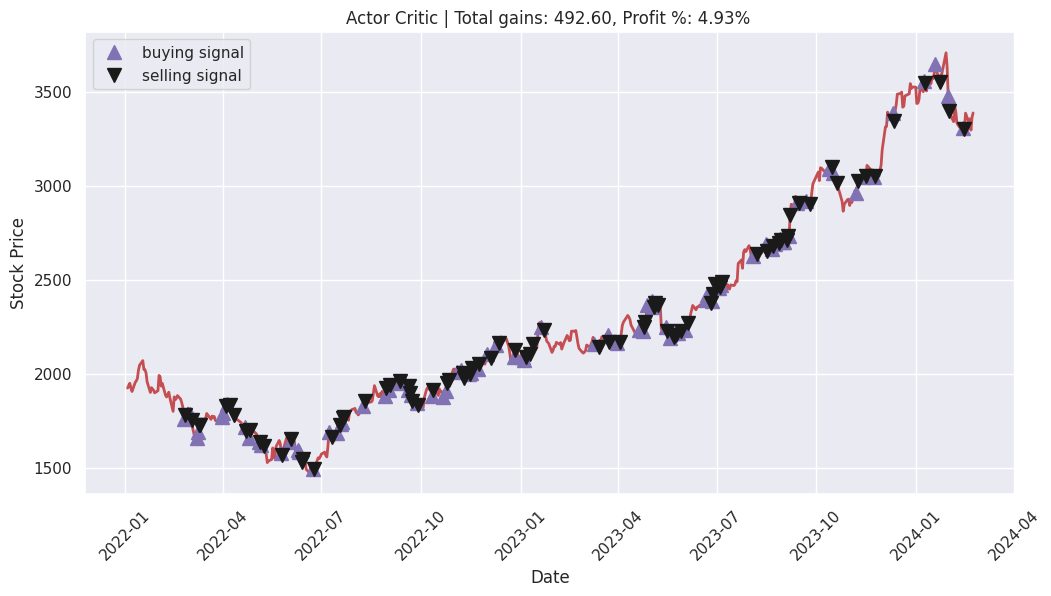

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd


# Extract date and close price
date = pd.to_datetime(df['Date'])
close = df['Close']

# Get the index of the first closing value
first_closing_index = close.first_valid_index()

# Extract the date and close price starting from the first closing value
date = date[first_closing_index:]
close = close[first_closing_index:]
plt.figure(figsize=(12, 6))
plt.plot(date, close, color='r', lw=2.)

# Plot markers for buying and selling signals
plt.plot(date[states_buy], close[states_buy], '^', markersize=10, color='m', label='buying signal')
plt.plot(date[states_sell], close[states_sell], 'v', markersize=10, color='k', label='selling signal')

plt.title('Actor Critic | Total gains: %.2f, Profit %%: %.2f%% '% (total_gains, invest))

# Set the locator for x-axis ticks to show dates every three months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the dataset
df = pd.read_csv('/content/LT.csv')

# Extract date and close price
date = pd.to_datetime(df['Date'])
close = df['Close']

# Get the index of the first closing value
first_closing_index = close.first_valid_index()

# Extract the date and close price starting from the first closing value
date = date[first_closing_index:]
close = close[first_closing_index:]

# Initialize variables for tracking trades and profits
total_trades = 0
total_profit = 0
monthly_profits = {}
current_month = None

# Loop through buying and selling signals to calculate trades and profits
for buy_date, sell_date in zip(date[states_buy], date[states_sell]):
    # Extract year and month from the buy date
    year = buy_date.year
    month = buy_date.month

    # Calculate profit for the current trade and add to total_profit
    buy_price = close[date == buy_date].values[0]
    sell_price = close[date == sell_date].values[0]
    trade_profit = sell_price - buy_price
    total_profit += trade_profit
    total_trades += 1

    # Add the trade profit to the corresponding month
    if year not in monthly_profits:
        monthly_profits[year] = {}
    if month not in monthly_profits[year]:
        monthly_profits[year][month] = []
    monthly_profits[year][month].append(trade_profit)

# Calculate and print metrics
average_profit_per_trade = total_profit / total_trades
annualized_return = (1 + total_profit / 100) ** (12 / len(date.dt.to_period("M").unique())) - 1

print(f"Total Trades: {total_trades}")
print(f"Total Profit: {total_profit:.2f}")
print(f"Average Profit per Trade: {average_profit_per_trade:.2f}")
print(f"Annualized Return: {annualized_return * 100:.2f}%")

Total Trades: 81
Total Profit: 492.60
Average Profit per Trade: 6.08
Annualized Return: 127.33%


In [ ]:
#Calculate performance metrics
def calculate_metrics(states_buy, states_sell, close_prices, initial_money):
    total_gains = total_profit

    # Calculate ROI based on initial investment
    ROI_initial_investment = (total_gains / initial_money) * 100

    # Calculate ROI based on total transactions
    total_investment = initial_money
    for buy_index in states_buy:
        total_investment -= close_prices[buy_index]
    for sell_index in states_sell:
        total_investment += close_prices[sell_index]
    ROI_total_investment = ((close_prices[-1] - total_investment) / total_investment) * 100

    # Calculate Sharpe Ratio (assuming risk-free rate is 0)
    returns = np.diff(close_prices) / close_prices[:-1]
    sharpe_ratio = np.sqrt(252) * np.mean(returns) / np.std(returns)

    # Calculate maximum drawdown
    max_drawdown = np.max(np.maximum.accumulate(close_prices) - close_prices) / np.max(np.maximum.accumulate(close_prices))

    # Calculate winning trades percentage
    winning_trades = len(states_sell) / (len(states_buy) + len(states_sell)) * 100

    # Calculate average return per trade
    avg_return_per_trade = total_gains / (len(states_buy) + len(states_sell))

    # Calculate average holding period
    holding_periods = [sell - buy for buy, sell in zip(states_buy, states_sell)]
    avg_holding_period = np.mean(holding_periods)

    # Other metrics such as risk of ruin, Calmar ratio, and Sortino ratio can be calculated as needed

    return total_gains, ROI_initial_investment, ROI_total_investment, sharpe_ratio, max_drawdown, winning_trades, avg_return_per_trade, avg_holding_period

#Simulate trading and compute performance metrics
initial_money = 10000
close_prices = df['Close'].values
total_gains, ROI_initial_investment, ROI_total_investment, sharpe_ratio, max_drawdown, winning_trades, avg_return_per_trade, avg_holding_period = calculate_metrics(
    states_buy, states_sell, close_prices, initial_money)

#Print performance metrics
print("Moving Average Performance Metrics:")
print("Total Gains: {:.2f}".format(total_gains))
print("Return on Investment (ROI) based on initial investment: {:.2f}%".format(ROI_initial_investment))
print("Return on Investment (ROI) based on total investment: {:.2f}%".format(ROI_total_investment))
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))
print("Maximum Drawdown: {:.2f}%".format(max_drawdown * 100))
print("Winning Trades Percentage: {:.2f}%".format(winning_trades))
print("Average Return per Trade: {:.2f}".format(avg_return_per_trade))
print("Average Holding Period: {:.2f}".format(avg_holding_period))

Moving Average Performance Metrics:
Total Gains: 492.60
Return on Investment (ROI) based on initial investment: 4.93%
Return on Investment (ROI) based on total investment: -67.71%
Sharpe Ratio: 1.30
Maximum Drawdown: 16.12%
Winning Trades Percentage: 50.00%
Average Return per Trade: 3.04
Average Holding Period: 1.77


In [ ]:
import numpy as np

def sharpe_ratio(returns, risk_free_rate=0):
    """
    Calculate Sharpe Ratio.

    Parameters:
        returns (ndarray or Series): Daily returns of the investment/portfolio.
        risk_free_rate (float, optional): Annual risk-free rate of return, default is 0.

    Returns:
        float: Sharpe Ratio.
    """
    avg_return = np.mean(returns)
    std_dev = np.std(returns)
    sharpe = (avg_return - risk_free_rate) / std_dev if std_dev != 0 else np.nan
    return sharpe

# Example usage:
if __name__ == "__main__":
    # Example returns data (replace with your own data)
    returns_data = np.random.normal(0.001, 0.02, 100)  # Generating random returns data for demonstration
    risk_free_rate = 0.02  # Assumed annual risk-free rate

    # Calculate Sharpe Ratio
    sharpe = sharpe_ratio(returns_data, risk_free_rate)

    print("Sharpe Ratio:", sharpe)


Sharpe Ratio: -0.8641168413791541


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/LT.csv')

# Extract date and close price
date = pd.to_datetime(df['Date'])
close = df['Close']

# Get the index of the first closing value
first_closing_index = close.first_valid_index()

# Extract the date and close price starting from the first closing value
date = date[first_closing_index:]
close = close[first_closing_index:]

# Initialize variables for tracking trades and profits
total_trades = 0
winning_trades = 0
total_profit = 0

# Loop through buying and selling signals to calculate trades and profits
for buy_date, sell_date in zip(date[states_buy], date[states_sell]):
    # Calculate profit for the current trade
    buy_price = close[date == buy_date].values[0]
    sell_price = close[date == sell_date].values[0]
    trade_profit = sell_price - buy_price

    # Increment total trades count
    total_trades += 1

    # Check if the trade resulted in a profit
    if trade_profit > 0:
        winning_trades += 1

    # Add the trade profit to the total profit
    total_profit += trade_profit

# Calculate winning trades percentage
winning_trades_percentage = (winning_trades / total_trades) * 100

print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {winning_trades}")
print(f"Winning Trades Percentage: {winning_trades_percentage:.2f}%")


Total Trades: 81
Winning Trades: 47
Winning Trades Percentage: 58.02%
